In [1]:
#https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
#https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/


# univariate multi-step vector-output stacked lstm example
# Importing the libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional,Dropout
from keras.layers import Dense
from keras.regularizers import L1L2
from numpy import hstack, vstack, newaxis
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)
%matplotlib inline

def qk(y_pred, y):
    return cohen_kappa_score(y_pred, y, weights='quadratic')

def plot_eval(real_stock_price, predicted_stock_price, num_features):
    print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
    print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
    mean_absolute_er = mean_absolute_error(real_stock_price, predicted_stock_price)
    print("mean_absolute_error: ", mean_absolute_er)
    #print("quadratic_cohen_kappa_score: ", qk(predicted_stock_price, real_stock_price))
    #real_stock_price, predicted_stock_price
    SS_Residual = sum((real_stock_price-predicted_stock_price)**2)
    SS_Total = sum((real_stock_price-np.mean(real_stock_price))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(real_stock_price)-1)/(len(real_stock_price)-num_features-1)
    print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)
    out_arr = np.subtract(predicted_stock_price, real_stock_price)
    fig = plt.figure(figsize=(12,8))
    # Visualising the results
    plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
    plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def add_datepart(df, fldnames, drop=False, time=False, errors="raise"):	
    if isinstance(fldnames,str):
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64
        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        #targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[n] = getattr(fld.dt, n.lower())
        df['Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)
    df.drop(['Elapsed','Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'], axis=1, inplace=True)
        

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	last_row = []
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			last_row = sequence[i:end_ix]
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y), last_row


def calc_feat(sequence, n_steps_in, n_steps_out, num_of_features=3):
    X= []
    size = len(sequence)
    skips = n_steps_in -1
    sz = size-skips
    for i in range(0,size-1): ##loop through each row in sequence
        vwap = 0
        vol = 0
        vchg = 0
        #print("i:", i)
        
        for j in range(n_steps_in): ## vwap rows loop
            #print("j:",j, " sz", sz, " size", size, " i", i)
            #print("High, Low, Close", sequence[i, 0:3])
            #print("Vol", sequence[i, 4])
            #print("Change", sequence[i, 3])
            vwap += (((np.sum(sequence[i, 0:3]))/3) * sequence[i, 4])
            vchg += (((sequence[i, 3])) * sequence[i, 4])
            vol += sequence[i, 4]
            i = i+1
            #print("vwap:", vwap, " vchg", vchg)
        #if vwap !=0  and vol != 0:
        #print("vol out:", vol)
        #print("---------------------------")
        X = np.append(X, vwap/vol) #vwap
        X = np.append(X, vchg/vol) #Change
        #X = np.append(X, sequence[i, 4]) #volume
        #X = np.append(X, sequence[i, 5]) #openInt
        X = np.append(X, sequence[i-1, 6]) #DTWEXB
        #X = np.append(X, sequence[i, 7]) #Year
        #X = np.append(X, sequence[i, 8]) #Mnt
        #X = np.append(X, sequence[i, 9]) #Week
        #X = np.append(X, sequence[i, 10]) #DayofMonth
        #X = np.append(X, sequence[i, 11]) #Dayofweek
        #X = np.append(X, sequence[i, 12]) #Dayofyear
        if (i == size):
            break
        i = i-skips    


    X = np.array(X.reshape(sz, num_of_features))
    print(X.shape)
    last_feat = X[-n_steps_out,:]
    X = X[0:-n_steps_out,:]
    print(X.shape)
    #X = X[:-(n_steps_out), :]
    return X, last_feat


def calc_pred(sequence, n_steps_in, n_steps_out):
    last_row = sequence[-(n_steps_in):]
    X= []
    k = 0 # row itreator
    size = len(last_row) + 1
    for i in range(n_steps_in, size):
        vwap = 0
        vol = 0
        vchg = 0
        for j in range(n_steps_in):
            if (k<i):
                print ("row ",last_row[k, 0:3])
                print ("vol ",last_row[k, 4])
                print ("chg ",last_row[k, 4])
                vwap += (((np.sum(last_row[k, 0:3]))/3) * last_row[k, 4])
                vchg += (((last_row[k, 3])) * last_row[k, 4])
                print ("vwap ",vwap)
                print ("vchg ",vchg)
                vol += last_row[k, 4]
                k = k+1
        
        X = np.append(X, vwap/vol) #vwap
        X = np.append(X, vchg/vol) #Change
    
    num_of_features = 2 #num_of_features
    sz = size-(n_steps_in)
    #X = np.array(X.reshape(sz, num_of_features)) 
    pred_seq = last_row[:,2]
    pred_seq = np.concatenate((pred_seq , X), axis=0)
    return pred_seq

# load dataset
# Importing the training set
dataset_train = pd.read_csv('C:/Users/hmnsh/repos/datastuff/Minnean/marketdata/zsh20_daily_price-history-12-13-2019.csv' ) #, nrows=10
#dataset_train = dataset_train[dataset_train["Volume"] != 0]

dataset_dxy = pd.read_csv('C:/Users/hmnsh/repos/datastuff/Minnean/marketdata/DTWEXBDEC13.csv')

Using TensorFlow backend.


In [2]:
dataset_dxy = dataset_dxy.replace(".", np.nan).fillna(method='ffill')
dataset_train = pd.merge(dataset_train, dataset_dxy,  left_on='Time', right_on='DATE', how='left')

In [3]:
dataset_train.tail()

,Time,Open,High,Low,Last,Change,Volume,Open Int,DATE,DTWEXB
519,12/9/2019,906.0,917.6,904.4,911.6,8.0,132290,262040,12/9/2019,129.8561
520,12/10/2019,912.0,916.6,911.0,915.4,3.6,62700,276435,12/10/2019,129.7891
521,12/11/2019,913.0,916.0,906.2,908.0,-7.4,102345,281621,12/11/2019,129.6916
522,12/12/2019,907.4,916.0,902.4,912.4,4.4,82257,297027,12/12/2019,129.3246
523,12/13/2019,920.0,931.4,916.0,921.4,9.0,91708,0,12/13/2019,129.1544


In [4]:
dataset_train.Time = pd.to_datetime(dataset_train.Time.str.replace('D', 'T'))
dataset_train = dataset_train.sort_values('Time')
dataset_train.drop(['DATE'], inplace=True, axis=1)
#dataset_train = dataset_train.astype({"Volume": np.float64, "Open Int": np.float64})
# choose a number of time stepscls
n_steps_in, n_steps_out = 6, 1

add_datepart(dataset_train, 'Time')

dataset_train.set_index('Time', inplace=True)
print(dataset_train.shape)
dataset_train.head()

(524, 14)


,Open,High,Low,Last,Change,Volume,Open Int,DTWEXB,Year,Month,Week,Day,Dayofweek,Dayofyear
Time,,,,,,,,,,,,,,
2017-11-15,985.0,985.0,985.0,985.0,6.5,0,0,120.5898,2017,11,46,15,2,319
2017-11-16,983.0,983.0,983.0,983.0,-2.0,0,0,120.3562,2017,11,46,16,3,320
2017-11-17,996.5,996.5,996.5,996.5,13.5,0,0,120.0765,2017,11,46,17,4,321
2017-11-20,998.5,998.5,998.5,998.5,2.0,0,0,120.3473,2017,11,47,20,0,324
2017-11-21,998.0,998.0,998.0,998.0,-0.5,0,0,120.0523,2017,11,47,21,1,325


In [5]:
# define input sequence
training_feat = dataset_train.iloc[:, 1:15].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
training_feat_scaled = sc.fit_transform(training_feat)

#X_feat = calc_feat(training_feat, n_steps_in, n_steps_out)
X_feat, pred_feat = calc_feat(training_feat_scaled, n_steps_in, n_steps_out)
#pred_seq= calc_pred(training_feat_scaled, n_steps_in, n_steps_out)

(519, 3)
(518, 3)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


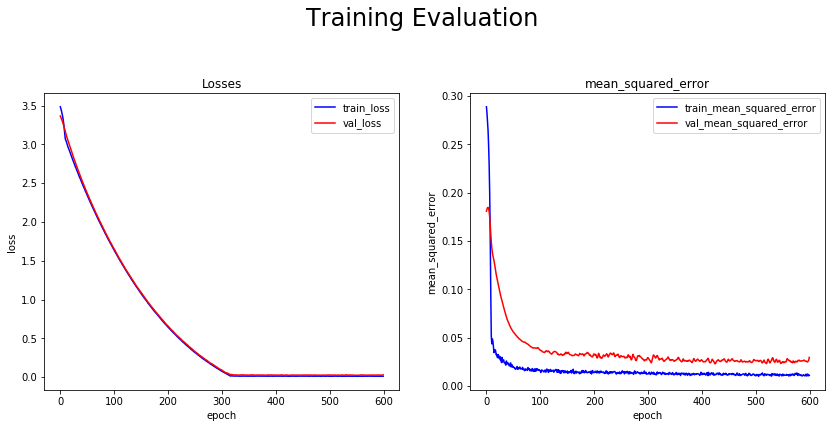

Day Prediction (Step):  1
sqrt mean_squared_error:  10.069535607389318
mean_squared_error:  101.39554734848136
mean_absolute_error:  8.159372135084508
R Squared: [0.8132212] 
Adjusted R Squared: [0.79411883]


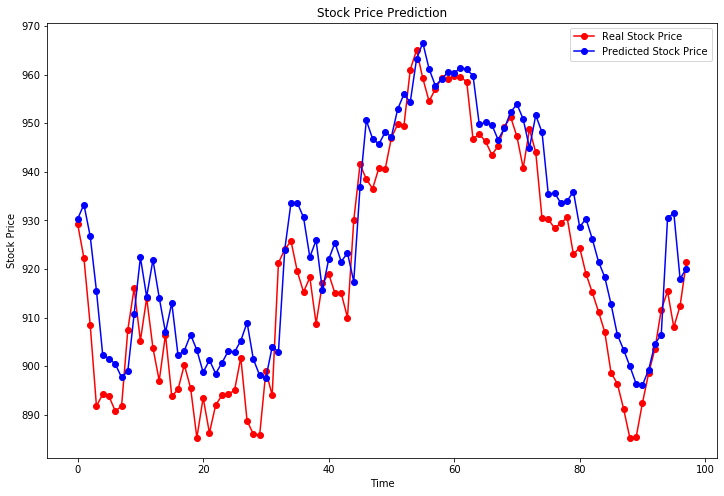

[13:38:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Day Prediction (Step):  1
sqrt mean_squared_error:  12.040676037121678
mean_squared_error:  144.97787943091618
mean_absolute_error:  9.897475884885207
R Squared: [0.73293902] 
Adjusted R Squared: [0.70562597]


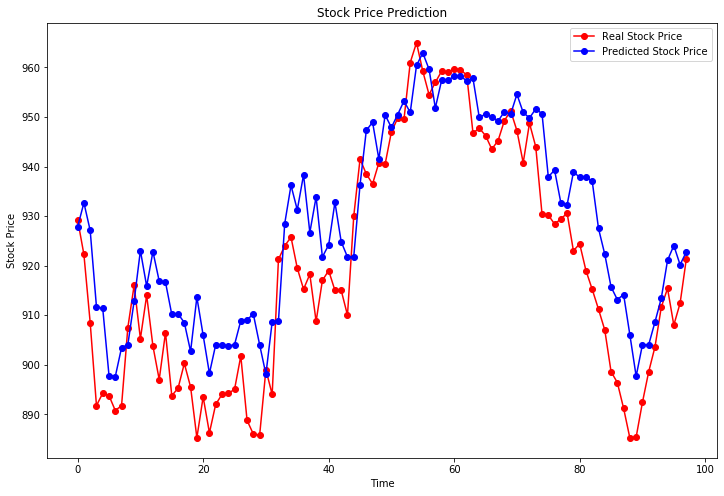

LSTM, ZSH, ZSK, ZSN [[927.9112]] [[942.1512]] [[955.1912]]
XGBoost, ZSH, ZSK, ZSN [[932.7715]] [[947.0115]] [[960.0515]]
ZSH, ZSK, ZSN [[930.3413]] [[944.5813]] [[957.62134]]


In [6]:
# define input sequence
training_set = dataset_train.iloc[:, 3:4].values

# Feature Scvvaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
raw_seq = sc.fit_transform(training_set)

# split into samples
X_whole, y_whole, last_row = split_sequence(raw_seq, n_steps_in, n_steps_out)

# summarize the data
#for i in range(len(X_whole)):
#	print(X_whole[i], y_whole[i])

X_whole = X_whole.reshape(X_whole.shape[0], X_whole.shape[1])
y_whole = y_whole.reshape(y_whole.shape[0], y_whole.shape[1])
y_whole = y_whole[:, n_steps_out-1:]
#step2 model - drop 1st row
#y_whole = y_whole[:,(n_steps_out-1):n_steps_out]
#trp_rows = X_feat.shape[0] - X_whole.shape[0]
#if trp_rows>0:
    
#    X_feat = X_feat[:-(trp_rows), :]
#Concate features
X_whole = hstack((X_whole, X_feat))
pred_seq = hstack((last_row.reshape(-1), pred_feat))
#print(X_whole.shape)

#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

Xf_whole = X_whole.copy()
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 9
X_train = X_train.reshape(X_train.shape[0], 1, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], 1, n_features)
X_test = X_test.reshape(X_test.shape[0], 1, n_features)
sp = pred_seq.shape[0]
pred_seq_reshape = pred_seq.reshape(1, 1, n_features)

Xf_whole = Xf_whole.reshape(Xf_whole.shape[0], 1, n_features)

# define model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True,bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(LSTM(10,bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["mean_squared_error"])
# fit model , batch_size=32
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=600, verbose=0, batch_size=96) #, validation_data=(X_valid, y_valid)
# demonstrate prediction
plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

# demonstrate prediction
yhat = model.predict(X_test, verbose=0)

for col in range(yhat.shape[1]):
    print("Day Prediction (Step): ", col+1)
    yhat[:,col:col+1] = sc.inverse_transform(yhat[:,col:col+1])
    y_test[:,col:col+1] = sc.inverse_transform(y_test[:,col:col+1])
    plot_eval(y_test[:,col:col+1],yhat[:,col:col+1], n_features)

## lstm pred
pred_lstm =  model.predict(pred_seq_reshape, verbose=0)

#XGBoost
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

Xf_whole = X_whole.copy()

#Train -valid and Test split in time order
from sklearn.metrics import mean_squared_error as MSE
from xgboost.sklearn import XGBRegressor
reg=XGBRegressor(learning_rate=0.01, n_estimators=600, n_jobs=1)
reg.fit(X_train, y_train)

# demonstrate prediction
yhat = reg.predict(X_test)
yhat = np.array(yhat.reshape(len(yhat), 1)) 
for col in range(yhat.shape[1]):
    print("Day Prediction (Step): ", col+1)
    yhat[:,col:col+1] = sc.inverse_transform(yhat[:,col:col+1])
    y_test[:,col:col+1] = sc.inverse_transform(y_test[:,col:col+1])
    plot_eval(y_test[:,col:col+1],yhat[:,col:col+1], n_features)


pred_reg= reg.predict(pred_seq.reshape(1, sp))

pred_final = (pred_lstm+pred_reg)/2
predicted_stock_price = sc.inverse_transform(pred_final.reshape(-1, 1))
pred_lstm = sc.inverse_transform(pred_lstm.reshape(-1, 1))
pred_reg = sc.inverse_transform(pred_reg.reshape(-1, 1))

pred_zsk = predicted_stock_price + 14.24
pred_zsn = predicted_stock_price + 27.28

print("LSTM, ZSH, ZSK, ZSN", pred_lstm, pred_lstm + 14.24, pred_lstm + 27.28)
print("XGBoost, ZSH, ZSK, ZSN", pred_reg, pred_reg + 14.24, pred_reg + 27.28)
print("ZSH, ZSK, ZSN", predicted_stock_price, pred_zsk, pred_zsn )

{'feature_names': ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8'], 'feature_types': None, 'handle': c_void_p(2184263793824), 'booster': 'gbtree', 'best_iteration': 599, 'best_ntree_limit': 600}


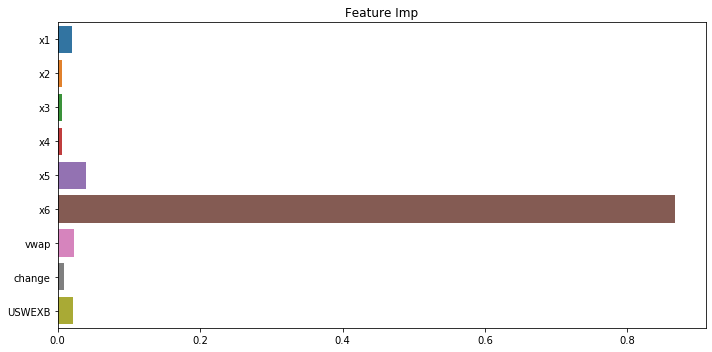

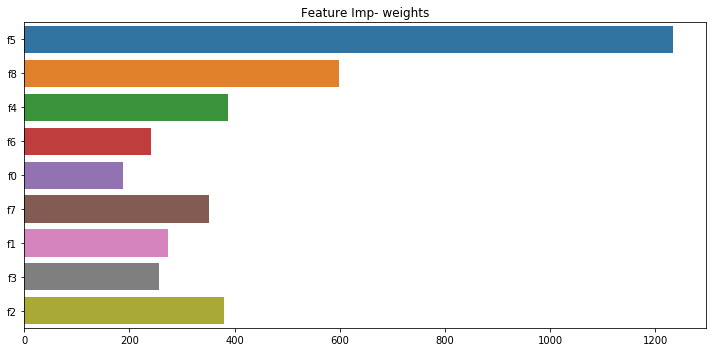

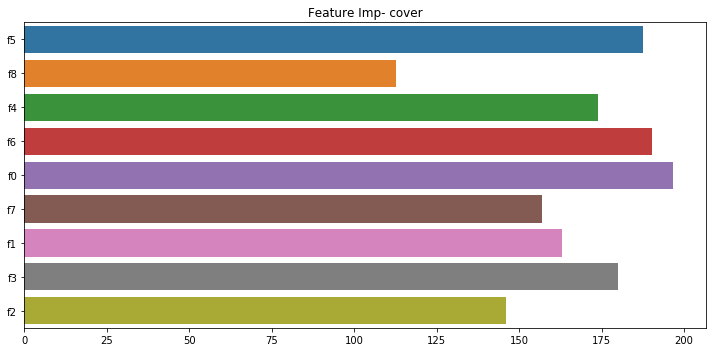

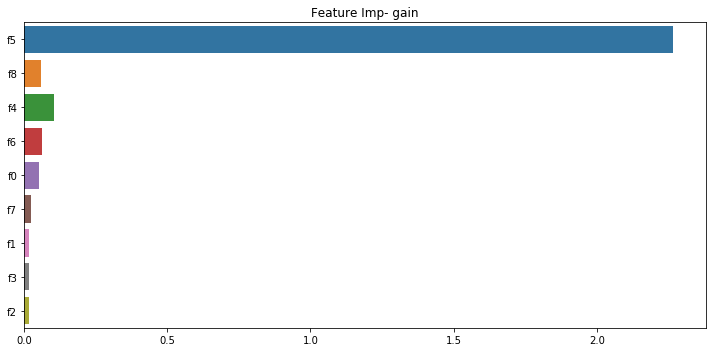

In [7]:
feat_imp = reg.feature_importances_
feat_cols =  ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'vwap', 'change', 'USWEXB']
feature_imp_weigth = reg.get_booster().get_score(importance_type='weight')
feature_imp_cover = reg.get_booster().get_score(importance_type='cover')
feature_imp_gain = reg.get_booster().get_score(importance_type='gain')

print(reg._Booster.__dict__)

def plot_imp(column_x, column_y, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=column_x, y=column_y)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
plot_imp(feat_imp, feat_cols, "Feature Imp")

plot_imp(list(feature_imp_weigth.values()) , list(feature_imp_weigth.keys()), "Feature Imp- weights")
plot_imp(list(feature_imp_cover.values()), list(feature_imp_cover.keys()), "Feature Imp- cover")
plot_imp(list(feature_imp_gain.values()), list(feature_imp_gain.keys()), "Feature Imp- gain")

In [24]:
X_display = pd.DataFrame(X_whole, columns=feat_cols)
X_display.head()

,x1,x2,x3,x4,x5,x6,vwap,change,USWEXB
0,0.637771,0.613003,0.780186,0.804954,0.798762,0.860681,0.752953,0.158931,-0.471370
1,0.613003,0.780186,0.804954,0.798762,0.860681,0.829721,0.784469,0.108298,-0.537250
2,0.780186,0.804954,0.798762,0.860681,0.829721,0.845201,0.822594,0.126582,-0.526995
3,0.804954,0.798762,0.860681,0.829721,0.845201,0.845201,0.833269,0.050633,-0.506269
4,0.798762,0.860681,0.829721,0.845201,0.845201,0.826625,0.836827,0.030942,-0.499967


In [36]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_display)
#Visualize multiple prediction
shap.force_plot(explainer.expected_value, shap_values[:500,:],  X_display.iloc[:500,:])

In [37]:
#Visualize a single prediction
shap.force_plot(explainer.expected_value, shap_values[4,:], X_display.iloc[4,:])

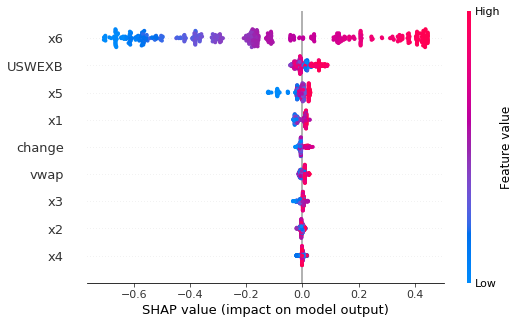

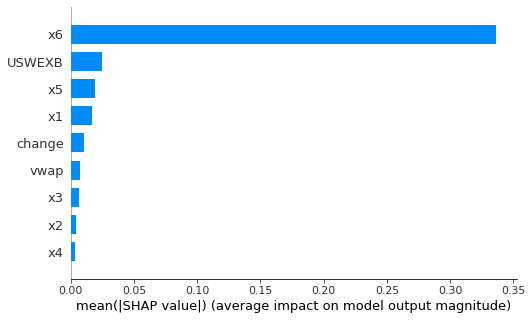

In [50]:
shap.summary_plot(shap_values, X_display, plot_size=(8,5))
shap.summary_plot(shap_values, X_display, plot_type="bar", plot_size=(8,5))

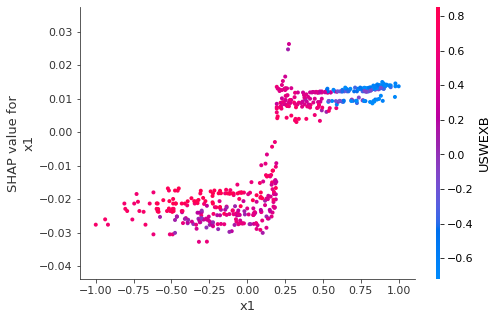

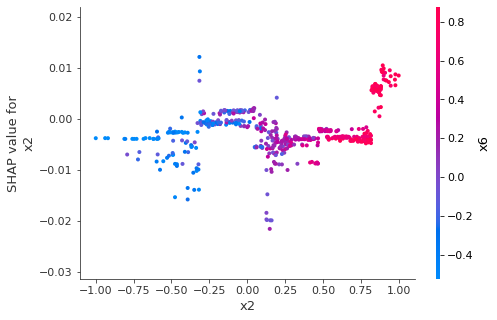

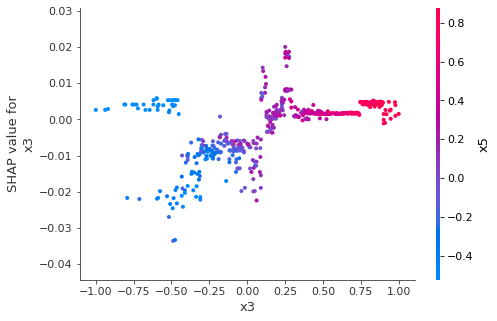

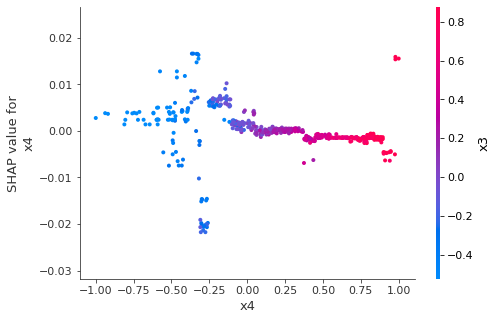

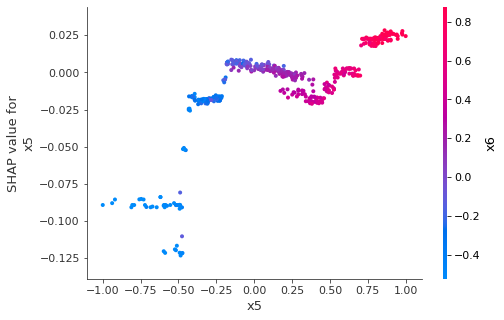

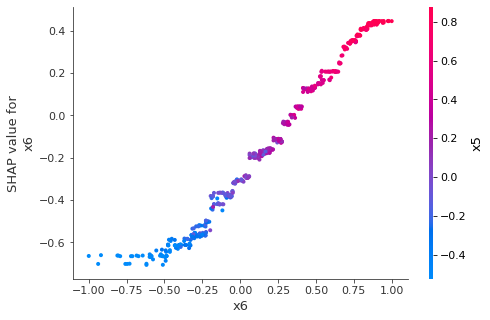

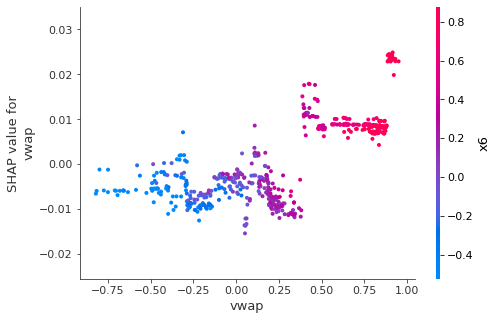

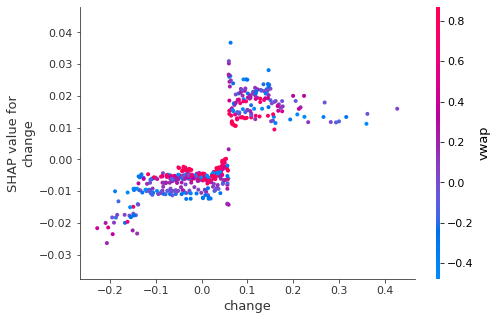

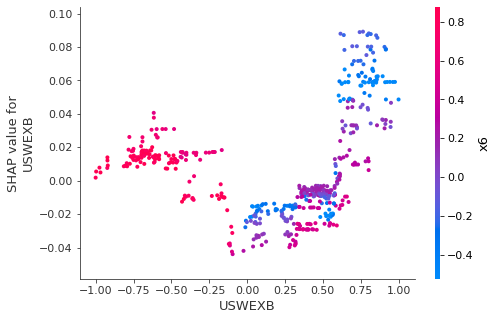

In [52]:
for name in X_display.columns:
    shap.dependence_plot(name, shap_values, X_display, display_features=X_display)

In [21]:
Xu,yu = shap.datasets.adult()
X_disp,y_disp = shap.datasets.adult(display=True)
print(type(X_disp))
print(type(Xu))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [23]:
X_disp.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
